In [13]:
## Standard libraries
import os
import json
import math
import numpy as np
import copy

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

/tmp/ipykernel_7576/3916073776.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [14]:
DATASET_PATH = "../data"
CHECKPOINT_PATH = "../saved_models/tutorial4"

# set the seed
def set_seed(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# ensure deterministic operations on GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print(f"Using device {device}")

Using device cuda:0


In [15]:
"""
Download pre-trained models
"""

import urllib.request
from urllib.error import HTTPError

# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial4/"
# Files to download
pretrained_files = ["FashionMNIST_SGD.config",    "FashionMNIST_SGD_results.json",    "FashionMNIST_SGD.tar",
                    "FashionMNIST_SGDMom.config", "FashionMNIST_SGDMom_results.json", "FashionMNIST_SGDMom.tar",
                    "FashionMNIST_Adam.config",   "FashionMNIST_Adam_results.json",   "FashionMNIST_Adam.tar"]


# create checkpoint path if not exist
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url} ...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [16]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.2861,), (0.3530,))])

train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader   = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader  = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

In [17]:
"""
Normalization mean normally [-1,1] and std [0,1]
"""

print("Mean", (train_dataset.data.float()/255.0).mean().item())
print("Std", (train_dataset.data.float()/255.0).std().item())

# verify the statistics by looking @ a single batch
imgs, _ = next(iter(train_loader))
print("Statistics of single batch:")
print(f"\tMean: {imgs.mean().item():5.3f}")
print(f"\tStandard deviation: {imgs.std().item():5.3f}")
print(f"\tMaximum: {imgs.max().item():5.3f}")
print(f"\tMinimum: {imgs.min().item():5.3f}")

Mean 0.28604060411453247
Std 0.3530242443084717
Statistics of single batch:
	Mean: 0.020
	Standard deviation: 1.011
	Maximum: 2.022
	Minimum: -0.810


In [18]:
"""
Building Neural Network
"""

class BaseNetwork(nn.Module):

    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        super().__init__()
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for i in range(1, len(layer_sizes)):
            layers.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]))
            layers.append(act_fn)
        layers.append(nn.Linear(layer_sizes[-1], num_classes))
        self.layers = nn.Sequential(*layers)

        self.config = {
            "act_fn": act_fn.__class__.__name__,
            "input_size": input_size,
            "num_classes": num_classes,
            "hidden_sizes": hidden_sizes
        }

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)


In [19]:
"""
Define identity class for demonstration purposes
"""
class Identity(nn.Module):
    def forward(self, x):
        return x

act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "identity": Identity
}

In [20]:
##############################################################

def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index%columns]
        sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat,
                     kde=use_kde and ((val_dict[key].max()-val_dict[key].min())>1e-8)) # Only plot kde if there is variance
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig

##############################################################

def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()

    ## Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

##############################################################

def visualize_gradients(model, color="C0", print_variance=False):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    model.zero_grad()
    preds = model(imgs)
    loss = F.cross_entropy(preds, labels) # Same as nn.CrossEntropyLoss, but as a function instead of module
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.view(-1).cpu().clone().numpy() for name, params in model.named_parameters() if "weight" in name}
    model.zero_grad()

    ## Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")

##############################################################

def visualize_activations(model, color="C0", print_variance=False):
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    feats = imgs.view(imgs.shape[0], -1)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(feats)
            if isinstance(layer, nn.Linear):
                activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()

    ## Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")


##############################################################

### Initialization
The variance of the input should be propagated through the model to the last layer, so that we have a similar standard deviation for the output neurons. If the variance would vanish the deeper we go in our model, it becomes much harder to optimize the model as the input to the next layer is basically a single constant value. Similarly, if the variance increases, it is likely to explode (i.e. head to infinity) the deeper we design our model. The second property we look out for in initialization techniques is a gradient distribution with equal variance across layers. If the first layer receives much smaller gradients than the last layer, we will have difficulties in choosing an appropriate learning rate.

In [21]:
model = BaseNetwork(act_fn=Identity()).to(device)

##### Constant Initialization
The first and the last layer have diverse gradient distributions while the other three layers have the same gradient for all weights (note that this value is unequal 0, but often very close to it). Having the same gradient for parameters that have been initialized with the same values means that we will always have the same value for those parameters. This would make our layer useless and reduce our effective number of parameters to 1. Thus, we cannot use a constant initialization to train our networks.

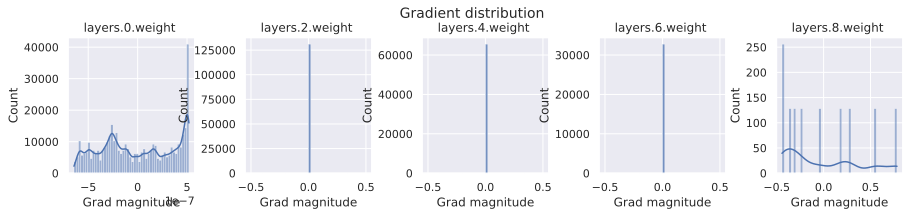

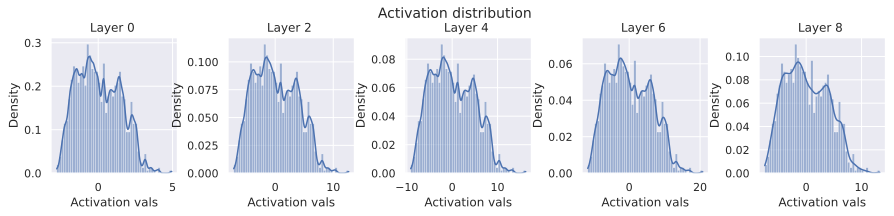

Layer 0 - Variance: 2.0591909885406494
Layer 2 - Variance: 13.500558853149414
Layer 4 - Variance: 22.128822326660156
Layer 6 - Variance: 36.27030944824219
Layer 8 - Variance: 14.856318473815918


In [22]:
def const_init(model, c=0.0):
    for name, param in model.named_parameters():
        param.data.fill_(c)

const_init(model, c=0.005)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

##### Constant Variance
Can see below that constant variance (sampled from a Gaussian) leads to vanishing or exploding gradients

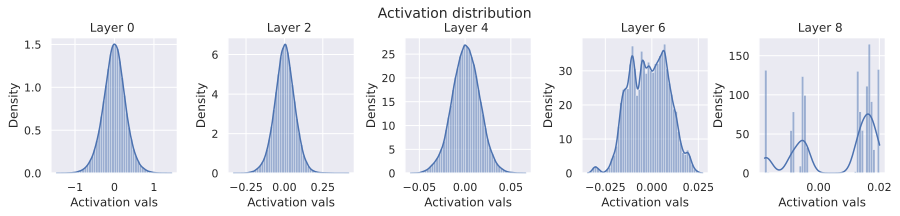

Layer 0 - Variance: 0.08248422294855118
Layer 2 - Variance: 0.004341918043792248
Layer 4 - Variance: 0.00022768987400922924
Layer 6 - Variance: 0.00010427324014017358
Layer 8 - Variance: 0.00016338381101377308


In [23]:
def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(std=std)

var_init(model, std=0.01)
visualize_activations(model, print_variance=True)

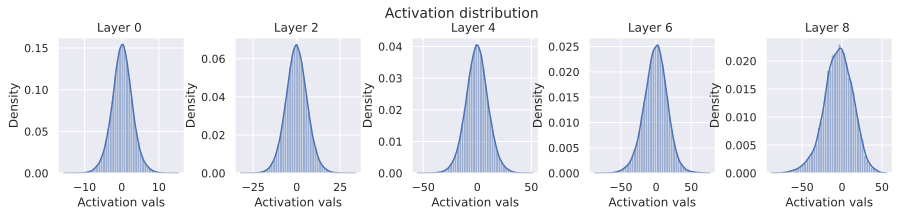

Layer 0 - Variance: 7.877697944641113
Layer 2 - Variance: 39.25226593017578
Layer 4 - Variance: 109.71202850341797
Layer 6 - Variance: 278.7244873046875
Layer 8 - Variance: 329.2292175292969


In [24]:
var_init(model, std=0.1)
visualize_activations(model, print_variance=True)

##### Finding appropriate initialization values
For this, we state two requirements: <br>
1. The mean of the activations should be zero
2. The variance of the activations should stay the same across every layer

Read this [tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial4/Optimization_and_Initialization.html) to get theory behind initialization


##### Variance inverse to input dimensions

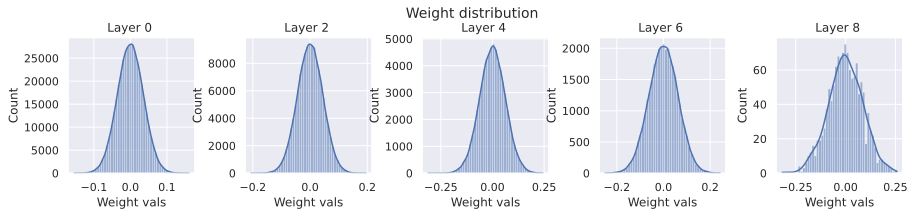

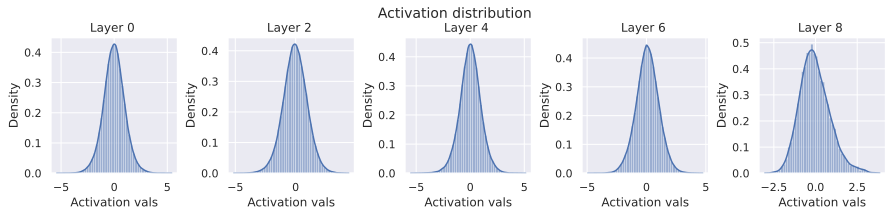

Layer 0 - Variance: 0.9935275912284851
Layer 2 - Variance: 0.9832162857055664
Layer 4 - Variance: 0.9425340294837952
Layer 6 - Variance: 0.9041345715522766
Layer 8 - Variance: 0.8100482821464539


In [25]:
def equal_var_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(std=math.sqrt(1/param.shape[1])) # param shape = [output, input dim]

equal_var_init(model)
visualize_weight_distribution(model)
visualize_activations(model, print_variance=True)

As expected, variance stays relatively constant across layers. Can also initialize with a normal distribution to prevent the chance of having very large or small weights.

We'd also like to stablize the gradient distribution across layers as well. This leads to the well-known Xavier intialization.

##### Xavier Initialization
The Xavier variance, as shown below, balances both the variance of gradients and activations.

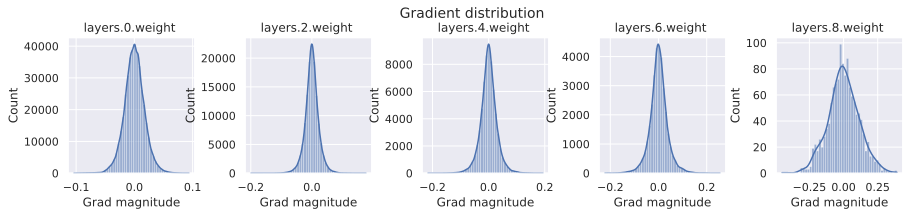

layers.0.weight - Variance: 0.0003018348943442106
layers.2.weight - Variance: 0.0004991401801817119
layers.4.weight - Variance: 0.0008559678681194782
layers.6.weight - Variance: 0.0013966697733849287
layers.8.weight - Variance: 0.013048860244452953


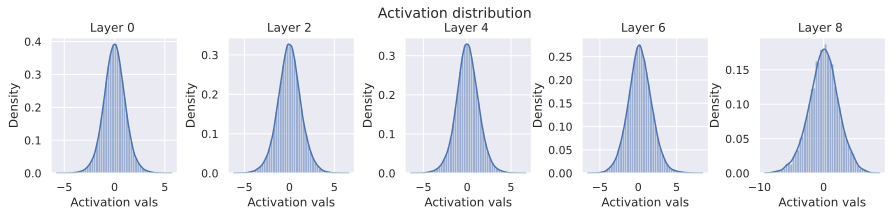

Layer 0 - Variance: 1.1828635931015015
Layer 2 - Variance: 1.7236759662628174
Layer 4 - Variance: 1.6858688592910767
Layer 6 - Variance: 2.460914373397827
Layer 8 - Variance: 5.404841423034668


In [26]:
def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            bound = math.sqrt(6)/math.sqrt(param.shape[0]+param.shape[1])
            param.data.uniform_(-bound, bound)

xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

Can see above that there is significantly higher variance in the output layer, but this is mainly due to the fact that the output dimensions is much smaller than the input layer. In addition, the activations were linear. Below, a non-linear activation function is used to see that Xavier initialization also works well for Tanh activation layers.

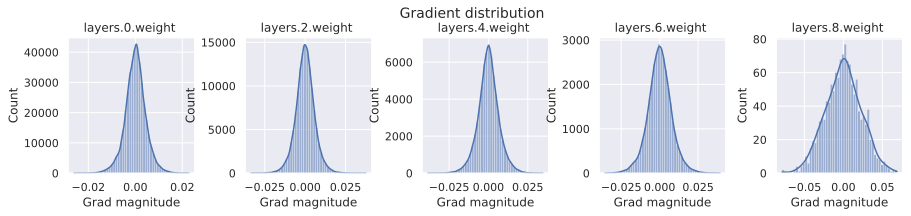

layers.0.weight - Variance: 1.9350763977854513e-05
layers.2.weight - Variance: 3.361075869179331e-05
layers.4.weight - Variance: 4.423045538715087e-05
layers.6.weight - Variance: 5.9367910580476746e-05
layers.8.weight - Variance: 0.000535499129910022


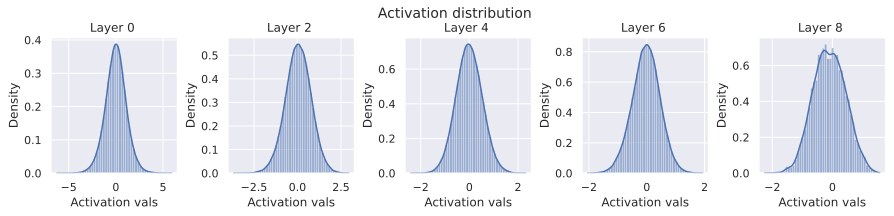

Layer 0 - Variance: 1.2310739755630493
Layer 2 - Variance: 0.5376343727111816
Layer 4 - Variance: 0.2863655984401703
Layer 6 - Variance: 0.2296122908592224
Layer 8 - Variance: 0.29046934843063354


In [27]:
model = BaseNetwork(act_fn=nn.Tanh()).to(device)
xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

##### Kaiming initialization

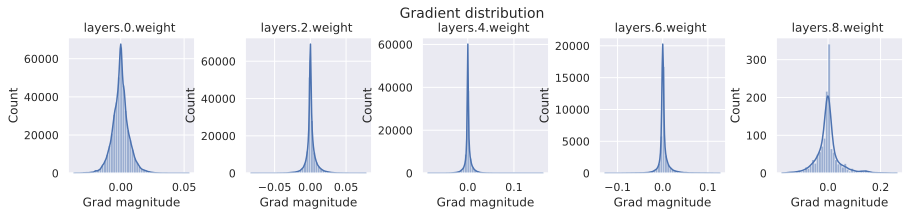

layers.0.weight - Variance: 4.6030567318666726e-05
layers.2.weight - Variance: 6.137042510090396e-05
layers.4.weight - Variance: 6.306111754383892e-05
layers.6.weight - Variance: 0.00016820774180814624
layers.8.weight - Variance: 0.002002255292609334


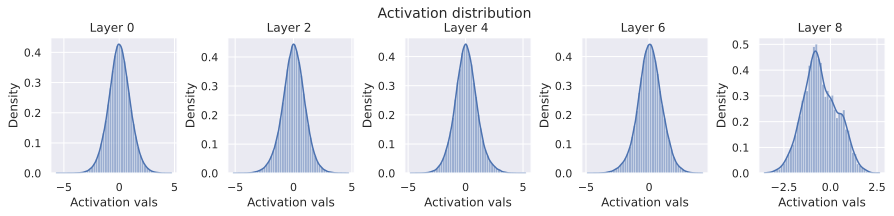

Layer 0 - Variance: 0.9814999103546143
Layer 2 - Variance: 0.9523278474807739
Layer 4 - Variance: 0.9687575101852417
Layer 6 - Variance: 0.9271107912063599
Layer 8 - Variance: 0.8455184698104858


In [33]:
def kaiming_init(model, factor=1):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        elif name.startswith("layers.0"): # first layer does not have ReLU applied on input
            param.data.normal_(0, math.sqrt(1/param.shape[1]))
        else:
            param.data.normal_(0, factor/math.sqrt(param.shape[1]))
    
model = BaseNetwork(act_fn=nn.ReLU()).to(device)
factor = torch.nn.init.calculate_gain('relu')
kaiming_init(model, factor)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

Can see from above that with the Kaiming initialization, the gradient and activation variances are stable. For different activation functions, such as Leaky ReLU the numerator factor is not 2. To get this constant, one can use the PyTorch function `torch.nn.init.calculate_gain(act_fn)`. See [link](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain) for more details.

In [34]:
model = BaseNetwork(act_fn=nn.LeakyReLU())
factor = torch.nn.init.calculate_gain('leaky_relu')
kaiming_init(model, factor)

### Optimization

In [35]:
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")

def _get_result_file(model_path, model_name):
    return os.path.join(model_path, model_name + "_results.json")

def load_model(model_path, model_name, net=None):
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        assert act_fn_name in act_fn_by_name, f"Unknown activation function \"{act_fn_name}\". Please add it to the \"act_fn_by_name\" dict."
        act_fn = act_fn_by_name[act_fn_name]()
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file))
    return net

def save_model(model, model_path, model_name):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

def train_model(net, model_name, optim_func, max_epochs=50, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST

    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print(f"Model file of \"{model_name}\" already exists. Skipping training...")
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "r") as f:
            results = json.load(f)
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Defining optimizer, loss and data loader
        optimizer =  optim_func(net.parameters())
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        results = None
        val_scores = []
        train_losses, train_scores = [], []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0., 0
            t = tqdm(train_loader_local, leave=False)
            for imgs, labels in t:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                true_preds += (preds.argmax(dim=-1) == labels).sum().item()
                count += labels.shape[0]
                t.set_description(f"Epoch {epoch+1}: loss={loss.item():4.2f}")
                train_losses.append(loss.item())
            train_acc = true_preds / count
            train_scores.append(train_acc)

            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch

    if results is None:
        load_model(CHECKPOINT_PATH, model_name, net=net)
        test_acc = test_model(net, test_loader)
        results = {"test_acc": test_acc, "val_scores": val_scores, "train_losses": train_losses, "train_scores": train_scores}
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "w") as f:
            json.dump(results, f)

    # Plot a curve of the validation accuracy
    sns.set()
    plt.plot([i for i in range(1,len(results["train_scores"])+1)], results["train_scores"], label="Train")
    plt.plot([i for i in range(1,len(results["val_scores"])+1)], results["val_scores"], label="Val")
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.ylim(min(results["val_scores"]), max(results["train_scores"])*1.01)
    plt.title(f"Validation performance of {model_name}")
    plt.legend()
    plt.show()
    plt.close()

    print((f" Test accuracy: {results['test_acc']*100.0:4.2f}% ").center(50, "=")+"\n")
    return results


def test_model(net, data_loader):
    """
    Test a model on a specified dataset.

    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

Optimizer is responsible for updating the network's params/weights with respect to some objective loss function. The learning rate is also an additional parameter of the optimizer (controls the step size in which the params move towards to the minima/maxima).

In [36]:
from abc import abstractmethod

class OptimizerTemplate:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr
    
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_() # important for 2nd-order optimizers
                p.grad.zero_()
    
    @torch.no_grad()
    def step(self):
        for p in self.params:
            if p.grad is None: # skip params with no gradients
                continue
        self.update_param(p)

    @abstractmethod
    def update_param(self, p):
        pass

In [37]:
# implement SGD

class SGD(OptimizerTemplate):
    def __init__(self, params, lr):
        super().__init__(params, lr)

    def update_param(self, p):
        p_update = -self.lr * p
        p.add_(p_update) # in-place update saves memory and does not create a computation graph

In [38]:
# concept of momentum: replaces the gradient in the update by an exponential average of all past gradients
# momentum(t) = beta*momentum(t-1) + (1 - beta)*gradient(t)
# weights(t) = weights(t-1) - lr*momentum(t)

class SGDMomentum(OptimizerTemplate):
    def __init__(self, params, lr, beta=0.0):
        super().__init__(params, lr)
        self.beta = beta
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params} # dict to save momentum(t)

    def update_param(self, p):
        self.param_momentum[p] = self.beta*self.param_momentum[p] + (1 - self.beta) * p.grad
        p_update = -self.lr * self.param_momentum[p]
        p.add_(p_update)

In [39]:
# Adam
# combines the idea of momentum with adaptive learning rate (based on exp avg of squared gradients) i.e. gradient norm
# add bias correction for momentum and adaptive lr for first iterations

class Adam(OptimizerTemplate):
    def __init__(self, params, lr, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.param_step = {p: 0 for p in self.params}
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        self.param_2nd_momentum = {p: torch.zeros_like(p.data) for p in self.params}

    def update_param(self, p):
        self.param_step[p] += 1
        self.param_momentum[p] = self.beta1 * self.param_momentum[p] + (1 - self.beta1) * p.grad
        self.param_2nd_momentum[p] = self.beta2 * self.param_2nd_momentum[p] + (1 - self.beta2) * p.grad**2

        bias_correction_1 = 1 - self.beta1 ** self.param_step[p]
        bias_correction_2 = 1 - self.beta2 ** self.param_step[p] 

        p_2nd_momentum = self.param_2nd_momentum[p] / bias_correction_2
        p_momentum = self.param_momentum[p] / bias_correction_1
        p_update = (-self.lr / ( torch.sqrt(p_2nd_momentum) + self.eps) ) * p_momentum
        
        p.add_(p_update)
        

### Comparing optimizers on model training

In [40]:
base_model = BaseNetwork(act_fn=nn.ReLU(), hidden_sizes=[512,256,256,128])
factor = torch.nn.init.calculate_gain("relu")
kaiming_init(base_model, factor=factor)

Model file of "FashionMNIST_SGD" already exists. Skipping training...


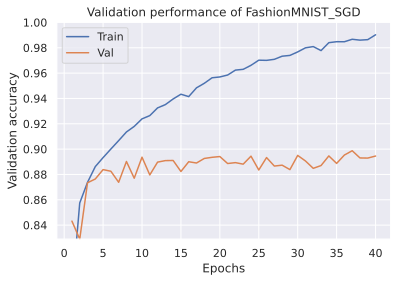

============= Test accuracy: 89.09% ==============



In [41]:
SGD_model = copy.deepcopy(base_model).to(device)
SGD_results = train_model(SGD_model, "FashionMNIST_SGD",
                          lambda params: SGD(params, lr=1e-1),
                          max_epochs=40, batch_size=256)

Model file of "FashionMNIST_SGDMom" already exists. Skipping training...


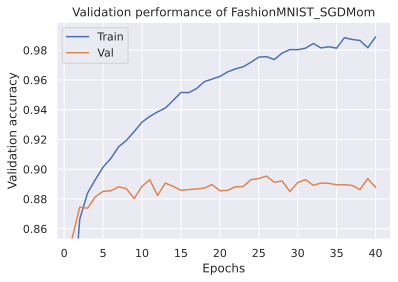

============= Test accuracy: 88.83% ==============



In [42]:
SGDMom_model = copy.deepcopy(base_model).to(device)
SGDMom_results = train_model(SGDMom_model, "FashionMNIST_SGDMom",
                             lambda params: SGDMomentum(params, lr=1e-1, momentum=0.9),
                             max_epochs=40, batch_size=256)

Model file of "FashionMNIST_Adam" already exists. Skipping training...


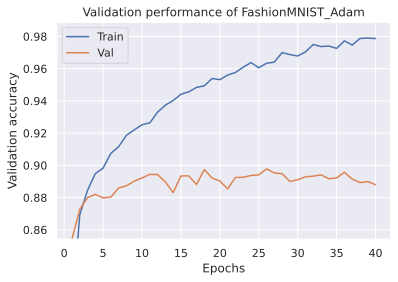

============= Test accuracy: 89.46% ==============



In [43]:
Adam_model = copy.deepcopy(base_model).to(device)
Adam_results = train_model(Adam_model, "FashionMNIST_Adam",
                           lambda params: Adam(params, lr=1e-3),
                           max_epochs=40, batch_size=256)

Though all the models have similar performance with different optimizers, it can be mainly attributed to good initialization as well. When initialization is bad, Adam normally performs better due to its adaptive learning rate.

#### Pathological curves
These type of surfaces are tricky for plain old SDG to find a global optimum due to very steep gradients. If the lr is too high, the optimizer may skip over it.

In [44]:
def pathological_curve_loss(w1, w2):
    # Example of a pathological curvature. There are many more possible, feel free to experiment here!
    x1_loss = torch.tanh(w1)**2 + 0.01 * torch.abs(w1)
    x2_loss = torch.sigmoid(w2)
    return x1_loss + x2_loss

/tmp/ipykernel_7576/4005370301.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d') if plot_3d else fig.gca()


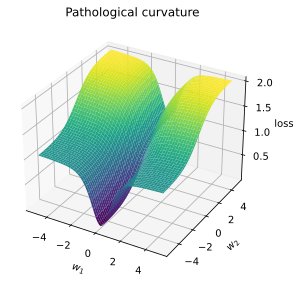

In [60]:
def plot_curve(curve_fn, x_range=(-5,5), y_range=(-5,5), plot_3d=False, cmap=cm.viridis, title="Pathological curvature"):
    fig = plt.figure()
    ax = fig.gca(projection='3d') if plot_3d else fig.gca()

    x = torch.arange(x_range[0], x_range[1], (x_range[1]-x_range[0])/100.)
    y = torch.arange(y_range[0], y_range[1], (y_range[1]-y_range[0])/100.)
    x, y = torch.meshgrid([x,y])
    z = curve_fn(x, y)
    x, y, z = x.numpy(), y.numpy(), z.numpy()

    if plot_3d:
        ax.plot_surface(x, y, z, cmap=cmap, linewidth=1, color="#000", antialiased=False)
        ax.set_zlabel("loss")
    else:
        ax.imshow(z.T[::-1], cmap=cmap, extent=(x_range[0], x_range[1], y_range[0], y_range[1]))
    plt.title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()
    return ax

sns.reset_orig()
_ = plot_curve(pathological_curve_loss, plot_3d=True)
plt.show()

In [85]:
def train_curve(optimizer_func, curve_func=pathological_curve_loss, num_updates=100, init=[5,5]):
    """
    Inputs:
        optimizer_func - Constructor of the optimizer to use. Should only take a parameter list
        curve_func - Loss function (e.g. pathological curvature)
        num_updates - Number of updates/steps to take when optimizing
        init - Initial values of parameters. Must be a list/tuple with two elements representing w_1 and w_2
    Outputs:
        Numpy array of shape [num_updates, 3] with [t,:2] being the parameter values at step t, and [t,2] the loss at t.
    """
    weights = nn.Parameter(torch.FloatTensor(init), requires_grad=True)
    optimizer = optimizer_func([weights])

    list_points = []
    for _ in range(num_updates):
        loss = curve_func(weights[0], weights[1])
        list_points.append(torch.cat([weights.data.detach(), loss.unsqueeze(dim=0).detach()], dim=0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    points = torch.stack(list_points, dim=0).numpy()
    return points

In [93]:
SGD_points = train_curve(lambda params: SGD(params, lr=0.1), num_updates=100)
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=10, beta=0.9))
Adam_points = train_curve(lambda params: Adam(params, lr=1))

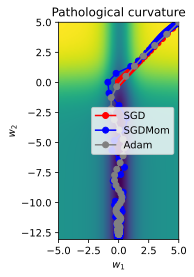

In [94]:
all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(pathological_curve_loss,
                x_range=(-np.absolute(all_points[:,0]).max(), np.absolute(all_points[:,0]).max()),
                y_range=(all_points[:,1].min(), all_points[:,1].max()),
                plot_3d=False)
ax.plot(SGD_points[:,0], SGD_points[:,1], color="red", marker="o", zorder=1, label="SGD")
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="blue", marker="o", zorder=2, label="SGDMom")
ax.plot(Adam_points[:,0], Adam_points[:,1], color="grey", marker="o", zorder=3, label="Adam")
plt.legend()
plt.show()

# for some weird reason, SGD_points explode immediately with lr > 1, so had to change lr of SGD down to 0.1 to make plot even readable

#### Steep Optima

/tmp/ipykernel_7576/4005370301.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d') if plot_3d else fig.gca()


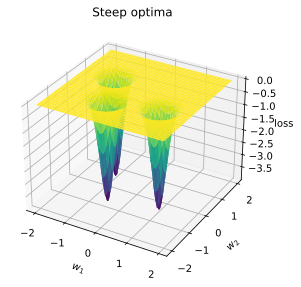

In [95]:
def bivar_gaussian(w1, w2, x_mean=0.0, y_mean=0.0, x_sig=1.0, y_sig=1.0):
    norm = 1 / (2 * np.pi * x_sig * y_sig)
    x_exp = (-1 * (w1 - x_mean)**2) / (2 * x_sig**2)
    y_exp = (-1 * (w2 - y_mean)**2) / (2 * y_sig**2)
    return norm * torch.exp(x_exp + y_exp)

def comb_func(w1, w2):
    z = -bivar_gaussian(w1, w2, x_mean=1.0, y_mean=-0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-1.0, y_mean=0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-0.5, y_mean=-0.8, x_sig=0.2, y_sig=0.2)
    return z

_ = plot_curve(comb_func, x_range=(-2,2), y_range=(-2,2), plot_3d=True, title="Steep optima")

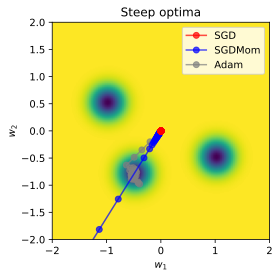

In [98]:
SGD_points = train_curve(lambda params: SGD(params, lr=.5), comb_func, init=[0,0])
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=1, beta=0.9), comb_func, init=[0,0])
Adam_points = train_curve(lambda params: Adam(params, lr=0.2), comb_func, init=[0,0])

all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(comb_func,
                x_range=(-2, 2),
                y_range=(-2, 2),
                plot_3d=False,
                title="Steep optima")
ax.plot(SGD_points[:,0], SGD_points[:,1], color="red", marker="o", zorder=3, label="SGD", alpha=0.7)
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="blue", marker="o", zorder=2, label="SGDMom", alpha=0.7)
ax.plot(Adam_points[:,0], Adam_points[:,1], color="grey", marker="o", zorder=1, label="Adam", alpha=0.7)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.legend()
plt.show()

# can see below that only Adam can learn where the gradients are
# challenging for optimizers, since most of the surface has a gradient of 0

#### What optimizer to take
Some network types can still be better optimized with SGD and learning rate scheduling than Adam. Nevertheless, Adam is the most commonly used optimizer in Deep Learning as it usually performs better than other optimizers, especially for deep networks.

NOTE: Adam can overfit the test set if the loss surface has very steep gradients. Best generalizability lies with functions with flatter curves in the loss surface.